# Pathway analysis in metabolomics: Pitfalls and best practice for the use of Over-representation Analysis

Cecilia Wieder <sup>1</sup>, Clément Frainay <sup>3</sup>, Nathalie Poupin <sup>3</sup>, Pablo Rodríguez-Mier <sup>3</sup>,
Florence Vinson <sup>3</sup>, Juliette Cooke <sup>3</sup>, Rachel Lai <sup>2</sup>, Jake Bundy <sup>1</sup>, Fabien Jourdan <sup>3</sup>, Timothy Ebbels <sup>1</sup>

<sup>1</sup> Department of Metabolism, Digestion, and Reproduction, Faculty of Medicine, Imperial College London, London SW7 2AZ, UK

<sup>2</sup> Department of Infectious Disease, Faculty of Medicine, Imperial College London, London SW7 2AZ, UK

<sup>3</sup> INRA, Toulouse University, INP, UMR 1331, Toxalim, Research Centre in Food Toxicology, 180 chemin de Tournefeuille, Toulouse, France

#### This notebook contains the code to run the following simulations:
- <a href='#s1'>Background list</a>
- <a href='#s2'>DA metabolite list size</a>
- <a href='#s3'>General vs. organism-specific pathway set</a>
- <a href='#s4'>Pathway database choice</a>
- <a href='#s5'>Metabolite misidentification</a>
- <a href='#s6'>Metabolite polarity</a>

#### The following scripts are required to run the code in this notebook. They should be saved in the same folder as this notebook. 
- process_datasets.py: Pre-processing of abundance matrices for the required datasets. 
- utils.py: Utilities for t-tests, ORA, and simulations.

All packages required are listed in the requirements.txt file. All simulations have been tested using Python version 3.8. Please note, some cells will take several minutes to run depending on the number of random samplings of the simulation. The default number of random samplings is 5 but can be adjusted using the nsim parameter which takes any integer as input. 

In [ ]:
# %%bash
# pip install -r requirements.txt 
# install the required packages

In [1]:
import utils
import process_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.api as sm
import os
from tqdm.notebook import tqdm

Process the example datasets

In [2]:
# Import the relevant datasets
pbar = tqdm(total=6)
quiros_data = process_datasets.Dataset("Quiros")
pbar.update(1)
yachida_data = process_datasets.Dataset("Yachida")
pbar.update(1)
stevens_data = process_datasets.Dataset("Stevens")
pbar.update(1)
labbe_data = process_datasets.Dataset("Labbe")
pbar.update(1)
fuhrer_dcus_data = process_datasets.Dataset("Fuhrer_dcuS")
pbar.update(1)
fuhrer_yfgm_data = process_datasets.Dataset("Fuhrer_yfgM")
pbar.update(1)
pbar.close()

# Import pathway sets
KEGG_human_pathways = pd.read_csv("../data/KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_eco_pathways = pd.read_csv("../data/KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_mouse_pathways = pd.read_csv("../data/KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
all_KEGG_human_bg = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_eco_bg = list(set([x for x in KEGG_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_mouse_bg = list(set([x for x in KEGG_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
KEGG_compounds_masses = pd.read_csv("../data/KEGG_compounds_masses_estimated.csv", names=["compound", "formula", "mass"])

# param grid
datasets = {"Labbé": [labbe_data.dem, labbe_data.background, KEGG_mouse_pathways, all_KEGG_mouse_bg, labbe_data.proc_mat,
                      [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Yachida": [yachida_data.dem, yachida_data.background, KEGG_human_pathways, all_KEGG_human_bg, yachida_data.proc_mat,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Stevens": [stevens_data.dem, stevens_data.background, KEGG_human_pathways, all_KEGG_human_bg, stevens_data.proc_mat,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Quirós": [quiros_data.dem, quiros_data.background, KEGG_human_pathways, all_KEGG_human_bg, quiros_data.proc_mat,
                       [i for i in range(0, 14, 1)], [i for i in range(0, 12, 1)], KEGG_compounds_masses],
            "Fuhrer (yfgM)": [fuhrer_yfgm_data.dem, fuhrer_yfgm_data.background, KEGG_eco_pathways, all_KEGG_eco_bg, fuhrer_yfgm_data.proc_mat,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses],
            "Fuhrer (dcuS)": [fuhrer_dcus_data.dem, fuhrer_dcus_data.background, KEGG_eco_pathways, all_KEGG_eco_bg, fuhrer_dcus_data.proc_mat,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses]}

print("Processing complete.")

  0%|          | 0/6 [00:00<?, ?it/s]

Processing complete.


<a id='s1'></a>
## Background list
How does using an assay-specific vs a non-assay-specific background set affect ORA results?

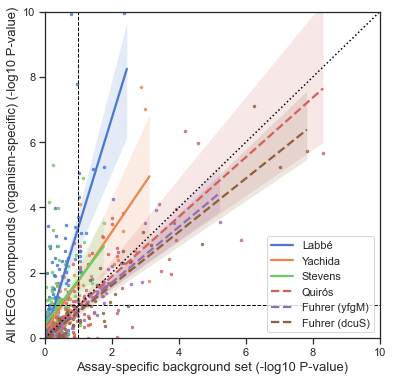

In [15]:
def plot_log_pvalues(db="KEGG"):
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    plt_dict = {}
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        ora_res_pvals = np.negative(np.log10(ora_res["P-value"].tolist()))
        ora_res_all_pvals = np.negative(np.log10(ora_res_all["P-value"].tolist()))
        plt_dict[i] = [ora_res_pvals, ora_res_all_pvals]

    plt.figure(figsize=(6, 6))
    sns.set_style("ticks")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]
        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         scatter_kws={'s': 6})
    # set dotted lines for TOF-MS data
    ax.lines[3].set_linestyle("--")
    ax.lines[4].set_linestyle("--")
    ax.lines[5].set_linestyle("--")
    ax.set_xlabel("Assay-specific background set (-log10 P-value)",
                  fontsize=13)
    ax.set_ylabel("All " + "KEGG" + " compounds (organism-specific) (-log10 P-value)",
                  fontsize=13)
    ax.set(ylim=(0, 10), xlim=(0, 10))
    plt.legend(plt_dict.keys(), fontsize=11, frameon=True)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
#     plt.tight_layout()
    plt.savefig("../../Figures/logp_plot_KEGG.tiff",
                dpi=600,
                format="tiff",
                pil_kwargs={"compression": "tiff_lzw"},
                transparent=True)
    plt.show()
plot_log_pvalues(db="KEGG")

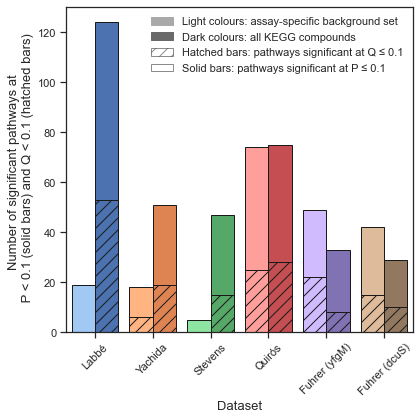

In [16]:
def plot_grouped_stacked_bar(db="KEGG"):
    dataframes = []
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        n_p_less_01 = len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01 = len(ora_res[ora_res["P-adjust"] < 0.1]["P-adjust"].tolist())
        n_p_less_01_all = len(ora_res_all[ora_res_all["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01_all = len(ora_res_all[ora_res_all["P-adjust"] < 0.1]["P-adjust"].tolist())
        df = pd.DataFrame([[n_q_less_01, n_p_less_01], [n_q_less_01_all, n_p_less_01_all]],
                          index=["Specified background list", "All " + db + " compounds"], columns=["P", "Q"])
        df["Name"] = i
        dataframes.append(df)

    dfall = pd.concat([pd.melt(i.reset_index(),
                               id_vars=["Name", "index"])  # transform in tidy format each df
                       for i in dataframes],
                      ignore_index=True)

    dfall.set_index(["Name", "index", "variable"], inplace=True)
    dfall["vcs"] = dfall.groupby(level=["Name", "index"]).cumsum()
    dfall.reset_index(inplace=True)
    sns.set_style("ticks")
    sns.set_palette("muted")
    plt.figure(figsize=(6, 6))
    for i, g in enumerate(dfall.groupby("variable")):
        ax = sns.barplot(data=g[1],
                         x="Name",
                         y="vcs",
                         hue="index",
                         zorder=-i,  # so first bars stay on top
                         edgecolor="k",
                         ci=None)
    ax.set_xlabel('Dataset', fontsize=13)
    # ax.set_xticks(x, labels, rotation='vertical')
    ax.set_ylabel('Number of significant pathways at \n P < 0.1 (solid bars) and Q < 0.1 (hatched bars)', fontsize=13)
    # labels = ["Quirós", "Yachida", "Stevens", "Labbé", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]

    # Set hatches for q-values bars
    # plt.subplots_adjust(right=0.8)
    plt.xticks(rotation=45)
    bars = ax.patches
    for i in range(6, 12):
        bars[i].set_color(sns.color_palette("deep", 6)[i - 6])
        bars[i].set_edgecolor("k")
    for i in range(0, 6):
        bars[i].set_color(sns.color_palette("pastel", 6)[i])
        bars[i].set_edgecolor("k")
    for i in range(12, 18):
        bars[i].set_color(sns.color_palette("pastel", 6)[i - 12])
        bars[i].set_edgecolor("k")
    for i in range(18, 24):
        bars[i].set_color(sns.color_palette("deep", 6)[i - 18])
        bars[i].set_edgecolor("k")
    for i in range(0, 12, 1):
        bars[i].set_hatch('//')

    specified_patch = mpatches.Patch(color='darkgray', label='Light colours: assay-specific background set')
    unspecified_patch = mpatches.Patch(color='dimgray', label='Dark colours: all KEGG compounds')
    hatched = mpatches.Patch(facecolor='white', hatch="//", label='Hatched bars: pathways significant at Q ≤ 0.1',
                             edgecolor='k', alpha=0.5)
    solid = mpatches.Patch(facecolor='white', label='Solid bars: pathways significant at P ≤ 0.1', edgecolor='k',
                           alpha=0.5)
    plt.legend(handles=[specified_patch, unspecified_patch, hatched, solid], fontsize=11)

    plt.tight_layout()
    plt.savefig("../../Figures/all_vs_experimental_barchart_KEGG.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"},
               transparent=True)
    plt.show()

plot_grouped_stacked_bar(db="KEGG")

### Background list size reduction
How does the size of the background list affect ORA results?

Labbé
Yachida
Stevens
Quirós
Fuhrer (yfgM)
Fuhrer (dcuS)


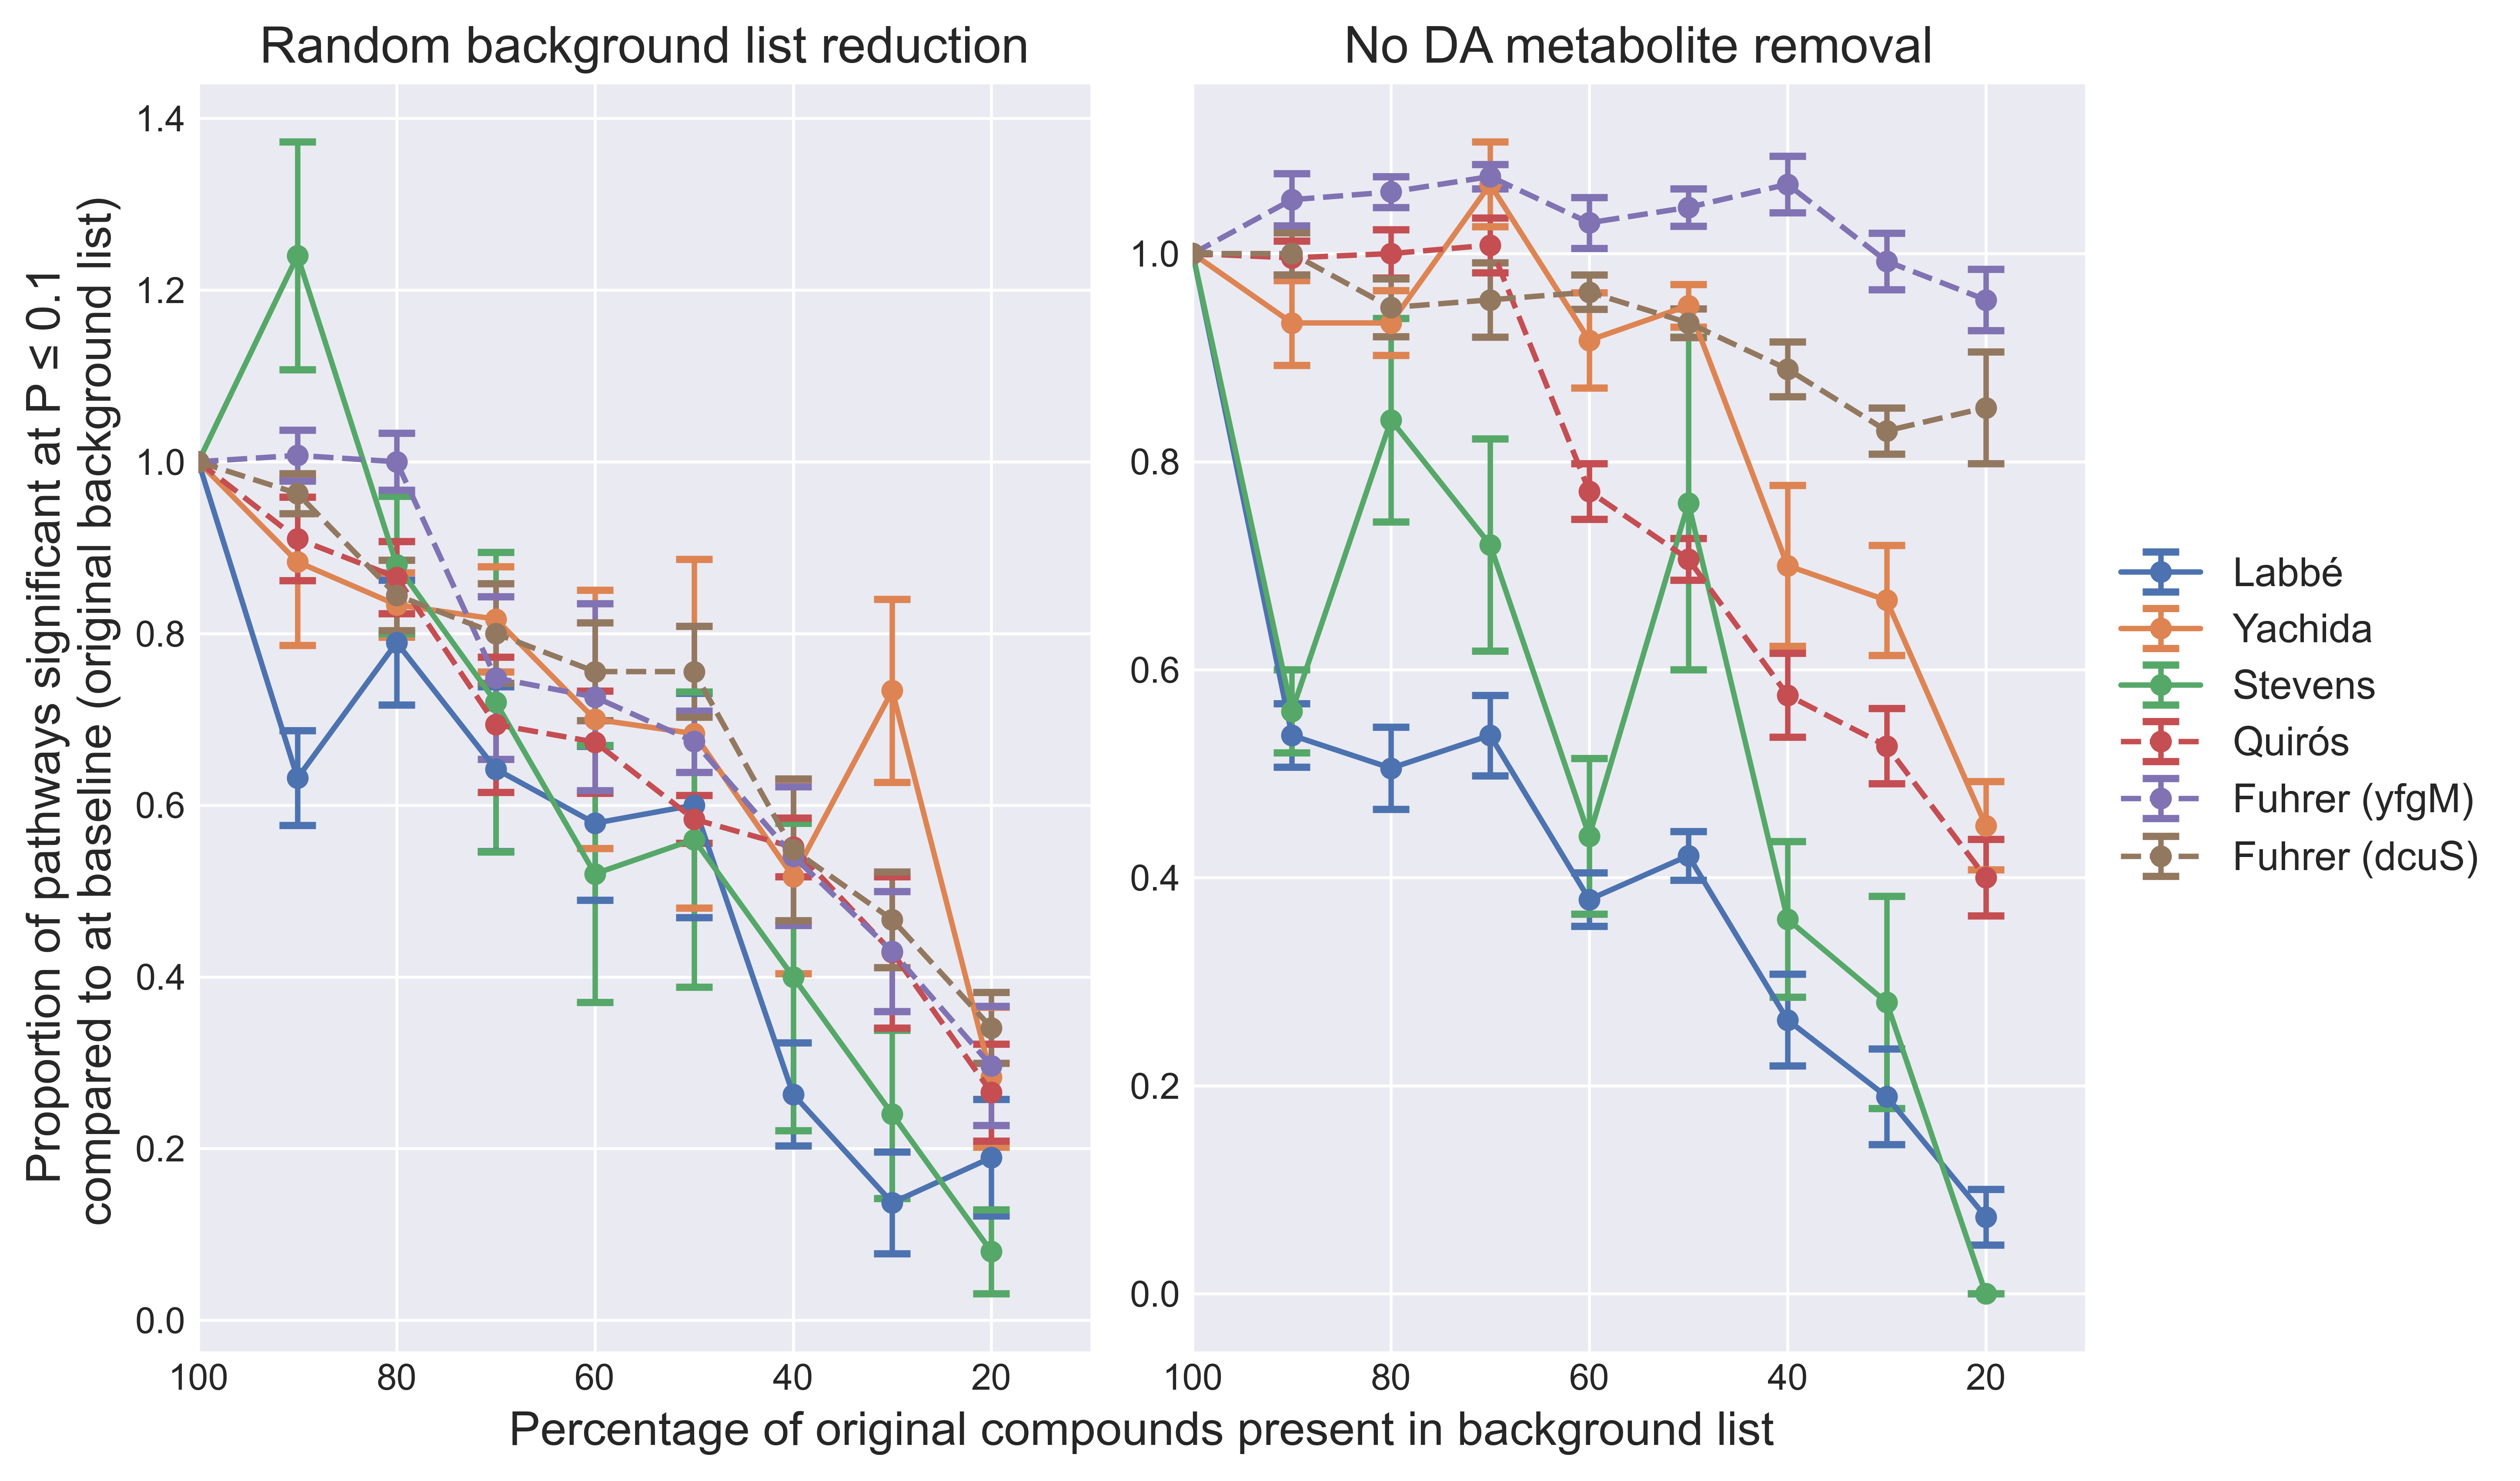

In [5]:
np.seterr(all="ignore")
def reduce_background_set(db="KEGG"):
    percentage_reductions_keep_DEM = [i for i in range(100, 10, -10)]
    percentage_reductions = [i for i in range(100, 10, -10)]
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_lists_keep_DEM = []
    results_lists = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Fuhrer"):
            for i in percentage_reductions:
                res = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0], d_sets[d][2],
                                                       nsim=5, keep_DEM=False, Zamboni=True)
                results_lists.append([d, i] + res)
            for i in percentage_reductions_keep_DEM:
                res_keep_DEM = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0],
                                                                d_sets[d][2], nsim=5, keep_DEM=True, Zamboni=True)
                results_lists_keep_DEM.append([d, i] + res_keep_DEM)
        else:
            for i in percentage_reductions:
                res = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0], d_sets[d][2],
                                                       nsim=5, keep_DEM=False, Zamboni=False)
                results_lists.append([d, i] + res)
            for i in percentage_reductions_keep_DEM:
                res_keep_DEM = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0],
                                                                d_sets[d][2], nsim=5, keep_DEM=True, Zamboni=False)
                results_lists_keep_DEM.append([d, i] + res_keep_DEM)

    res_df = pd.DataFrame(results_lists,
                          columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                   "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                   "q_std", "sd_proportion_p_vals"])
    res_df_keep_DEM = pd.DataFrame(results_lists_keep_DEM,
                                   columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                            "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                            "q_std", "sd_proportion_p_vals"])

    simulation_res = res_df
    simulation_res_keep_DEM = res_df_keep_DEM
    with plt.style.context('seaborn-darkgrid'):
        sns.set_palette("deep")
        fig = plt.figure(figsize=(10, 6), dpi=600)
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax1.set_title("Random background list reduction", fontsize=14)
        for i in d_sets.keys():
            if i in ["Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]:
                ax1.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage reduction'],
                             simulation_res[simulation_res["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res[simulation_res["Dataset"] == i]['sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="--", capsize=5, markeredgewidth=2, markersize=4)
            else:
                ax1.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage reduction'],
                             simulation_res[simulation_res["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res[simulation_res["Dataset"] == i]['sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax1.set_xlim(100, 10)
        ax2.set_title("No DA metabolite removal", fontsize=14)
        for i in d_sets.keys():
            if i in ["Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]:
                ax2.errorbar(simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['Percentage reduction'],
                             simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i][
                                 'sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="--", capsize=5, markeredgewidth=2, markersize=4)
            else:
                ax2.errorbar(simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['Percentage reduction'],
                             simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i][
                                 'sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax2.set_xlim(100, 10)
        handles, labels = ax1.get_legend_handles_labels()
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.grid(False)

        plt.ylabel("Proportion of pathways significant at P ≤ 0.1 \n compared to at baseline (original background list)",
                   fontsize=13)
        plt.xlabel("Percentage of original compounds present in background list", fontsize=13)
        plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
        plt.tight_layout()
        plt.savefig("background_list_reduction_proportion_KEGG_new2.png", dpi=600)
        plt.show()

reduce_background_set(db="KEGG")

<a id='s2'></a>
## List of input metabolites
How does the DA metabolite cutoff threshold affect ORA results?

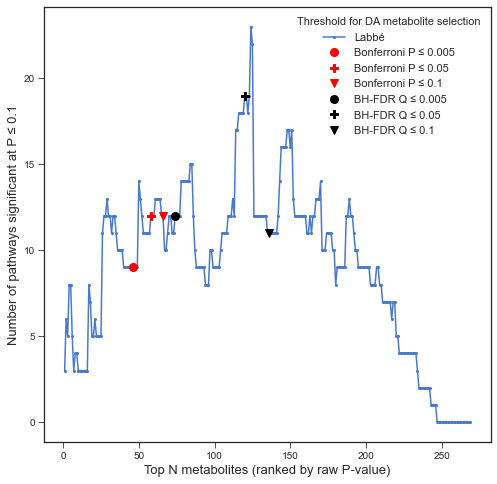

In [3]:
import matplotlib

def vary_dam_size_single_rankbyp(dataset):
    multiple_test_options = ["bonferroni", "fdr_bh"]
    res_list = []
    for d in [dataset]:
        if d.startswith("Fuhrer"):
            p_vals_dict = {}
            for x in datasets[d][4].T.itertuples():
                zscore = x[1]
                pval = stats.norm.cdf(zscore)
                p_vals_dict[x[0]] = pval
            pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
            padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
            pvals_df["P-adjust"] = padj
            pvals_df["ranked_padj"] = stats.rankdata(pvals_df["P-adjust"], method='min')
            pvals_df = pvals_df.sort_values(by="ranked_padj")

            max_rank = pvals_df["ranked_padj"].max()
            for i in range(1, len(pvals_df["P-adjust"]) + 1):
                metabolite_rank = pvals_df.iloc[i - 1, 2]
                DA_metabolites = pvals_df[pvals_df["ranked_padj"] <= metabolite_rank].index.tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, i, m, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])

        else:
            t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], "fdr_bh")
            t_test_res["ranked_p"] = stats.rankdata(t_test_res["P-value"], method='min')
            t_test_res = t_test_res.sort_values(by="ranked_p")
            # t_test_res.to_csv("Labbe_ttest_res" + m + ".csv")

            max_rank = t_test_res["ranked_p"].max()
            for i in range(1, len(t_test_res["Metabolite"]) + 1):
                metabolite_rank = t_test_res.iloc[i - 1, 3]
#                 print("Metabolite:", i, "rank:", metabolite_rank)
                DA_metabolites = t_test_res[t_test_res["ranked_p"] <= metabolite_rank]["Metabolite"].tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, i, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])

    res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "n_p_less_01"])

    # add annotations
    cutoffs = [0.005, 0.05, 0.1]
    annotations = []
    for d in [dataset]:
        for c in cutoffs:
            for m in multiple_test_options:
                if d.startswith("Fuhrer"):
                    p_vals_dict = {}
                    for x in datasets[d][4].T.itertuples():
                        zscore = x[1]
                        pval = stats.norm.cdf(zscore)
                        p_vals_dict[x[0]] = pval
                    pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
                    padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
                    pvals_df["P-adjust"] = padj
                    DA_metabolites = pvals_df[pvals_df["P-adjust"] <= c].index.tolist()
                    percentage = (len(DA_metabolites) / len(datasets[d][1])) * 100
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, percentage,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])
                else:
                    t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                    DA_metabolites = t_test_res[t_test_res["P-adjust"] <= c]["Metabolite"].tolist()
                    n_DA = len(DA_metabolites)
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, n_DA,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, n_DA, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])

    cutoffs_df = pd.DataFrame(annotations)
    cutoffs_bonferroni = cutoffs_df[cutoffs_df[4] == "bonferroni"]
    cutoffs_FDR_BH = cutoffs_df[cutoffs_df[4] == "fdr_bh"]
    res_df = res_df.sort_values(by='Cutoff_P')

    with plt.style.context('seaborn-ticks'):
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
        cols = sns.color_palette("muted", 8)
        for num, i in enumerate([dataset]):
            ax1.plot(res_df[res_df["Dataset"] == i]['Cutoff_P'].to_list(),
                     res_df[res_df["Dataset"] == i]['n_p_less_01'].tolist(), 'o',
                     label=i, linestyle='-', color=cols[num], markersize=2)
            
            ax1.plot(cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.005][1].to_list(),
                     cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.005][2].tolist(), 'o',
                     label="Bonferroni P ≤ 0.005", linestyle="None", color="red", markersize=8)
            ax1.plot(cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.05][1].to_list(),
                     cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.05][2].tolist(), 'P',
                     label="Bonferroni P ≤ 0.05", linestyle="None", color="red", markersize=8)
            ax1.plot(cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.1][1].to_list(),
                     cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.1][2].tolist(), 'v',
                     label="Bonferroni P ≤ 0.1", linestyle="None", color="red", markersize=8)
            
            ax1.plot(cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.005][1].to_list(),
                     cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.005][2].tolist(), 'o',
                     label="BH-FDR Q ≤ 0.005", linestyle="None", color="black", markersize=8)
            ax1.plot(cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.05][1].to_list(),
                     cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.05][2].tolist(), 'P',
                     label="BH-FDR Q ≤ 0.05", linestyle="None", color="black", markersize=8)
            ax1.plot(cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.1][1].to_list(),
                     cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.1][2].tolist(), 'v',
                     label="BH-FDR Q ≤ 0.1", linestyle="None", color="black", markersize=8)

        plt.legend(title="Threshold for DA metabolite selection", fontsize=11, title_fontsize=11)
        ax1.set_ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
        ax1.set_xlabel("Top N metabolites (ranked by raw P-value)", fontsize=13)

        plt.savefig("../../Figures/Figure3.tiff",
                    dpi=600,
                    format="tiff",
                    pil_kwargs={"compression": "tiff_lzw"},
                   transparent=True)
        plt.show()


vary_dam_size_single_rankbyp("Labbé")


Running ORA for each dataset...


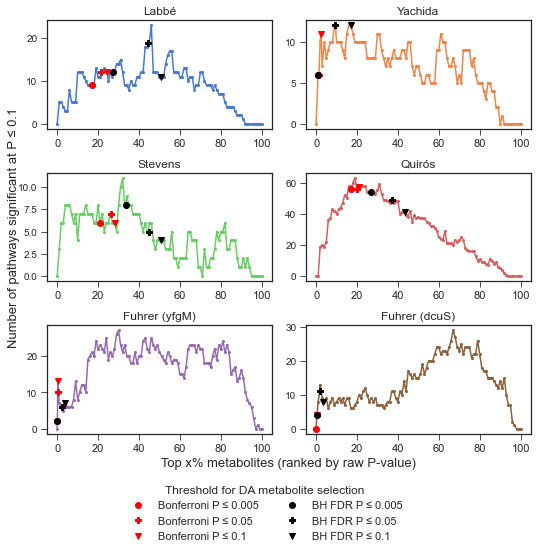

In [6]:
# Note this figure takes a few minutes to generate
import matplotlib
from tqdm.notebook import tqdm

proportion_of_bg = [i for i in range(1, 101, 1)]
multiple_test_options = ["bonferroni", "fdr_bh"]
res_list = []
print("Running ORA for each dataset...")
for d in tqdm(datasets.keys()):
    res_list.append([d, 0, 0])
    for p in proportion_of_bg:
        if d.startswith("Fuhrer"):
            p_vals_dict = {}
            for x in datasets[d][4].T.itertuples():
                zscore = x[1]
                pval = stats.norm.cdf(zscore)
                p_vals_dict[x[0]] = pval
            pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
            padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method="fdr_bh")[1]
            pvals_df["P-adjust"] = padj
            pvals_df["ranked_p"] = stats.rankdata(pvals_df["P-value"], method='min')
            pvals_df = pvals_df.sort_values(by="ranked_p")
            select_up_to = int((len(pvals_df["P-value"]) - 1) * (p / 100))
            selected_rank = pvals_df.iloc[select_up_to, 2]
            DA_metabolites = pvals_df[pvals_df["ranked_p"] <= selected_rank].index.tolist()
            ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
            res_list.append([d, p, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])
        else:
            t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], "fdr_bh")
            t_test_res["ranked_p"] = stats.rankdata(t_test_res["P-value"], method='min')
            t_test_res = t_test_res.sort_values(by="ranked_p")
            select_up_to = int((len(t_test_res["Metabolite"]) - 1) * (p / 100))
            selected_rank = t_test_res.iloc[select_up_to, 3]
            DA_metabolites = t_test_res[t_test_res["ranked_p"] <= selected_rank]["Metabolite"].tolist()
            ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
            res_list.append([d, p, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])
res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "n_p_less_01"])

# add annotations
cutoffs = [0.005, 0.05, 0.1]
annotations = []
for d in datasets.keys():
    for c in cutoffs:
        for m in multiple_test_options:
            if d.startswith("Fuhrer"):
                p_vals_dict = {}
                for x in datasets[d][4].T.itertuples():
                    zscore = x[1]
                    pval = stats.norm.cdf(zscore)
                    p_vals_dict[x[0]] = pval
                pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
                padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
                pvals_df["P-adjust"] = padj
                DA_metabolites = pvals_df[pvals_df["P-adjust"] <= c].index.tolist()
                percentage = (len(DA_metabolites) / len(datasets[d][1])) * 100
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_df.loc[len(res_df), :] = [d, percentage,
                                              len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                annotations.append(
                    [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])
            else:
                t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                DA_metabolites = t_test_res[t_test_res["P-adjust"] <= c]["Metabolite"].tolist()
                percentage = (len(DA_metabolites) / len(t_test_res["Metabolite"])) * 100
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_df.loc[len(res_df), :] = [d, percentage,
                                              len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                annotations.append(
                    [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])


cutoffs_df = pd.DataFrame(annotations)
cutoffs_bonferroni = cutoffs_df[cutoffs_df[4] == "bonferroni"]
cutoffs_FDR_BH = cutoffs_df[cutoffs_df[4] == "fdr_bh"]
res_df = res_df.sort_values(by='Cutoff_P')

with plt.style.context('seaborn-ticks'):
    fig, axs = plt.subplots(3,2, figsize=(8, 8))
    axs = axs.ravel()
    cols = sns.color_palette("muted", 8)
    for num, i in enumerate(datasets):
        cutoffs_bonferroni_dset = cutoffs_bonferroni[cutoffs_bonferroni[3] == i]
        cutoffs_FDR_BH_dset = cutoffs_FDR_BH[cutoffs_FDR_BH[3] == i]
        axs[num].plot(res_df[res_df["Dataset"] == i]['Cutoff_P'].to_list(),
                 res_df[res_df["Dataset"] == i]['n_p_less_01'].tolist(), 'o',
                 label=i, linestyle='-', color=cols[num], markersize=2)
        axs[num].set_title(i)

        axs[num].plot(cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.005][1].to_list(),
                 cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.005][2].tolist(), 'o',
                 label="Bonferroni P ≤ 0.005", linestyle="None", color="red", markersize=6)
        axs[num].plot(cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.05][1].to_list(),
                 cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.05][2].tolist(), 'P',
                 label="Bonferroni P ≤ 0.05", linestyle="None", color="red", markersize=6)
        axs[num].plot(cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.1][1].to_list(),
                 cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.1][2].tolist(), 'v',
                 label="Bonferroni P ≤ 0.1", linestyle="None", color="red", markersize=6)

        axs[num].plot(cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.005][1].to_list(),
                 cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.005][2].tolist(), 'o',
                 label="BH-FDR Q ≤ 0.005", linestyle="None", color="black", markersize=6)
        axs[num].plot(cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.05][1].to_list(),
                 cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.05][2].tolist(), 'P',
                 label="BH-FDR Q ≤ 0.05", linestyle="None", color="black", markersize=6)
        axs[num].plot(cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.1][1].to_list(),
                 cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.1][2].tolist(), 'v',
                 label="BH-FDR Q ≤ 0.1", linestyle="None", color="black", markersize=6)


#             axs[num].set_ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
#             axs[num].set_xlabel("Top N metabolites (ranked by raw P-value)", fontsize=13)
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Top x% metabolites (ranked by raw P-value)", fontsize=13)
    plt.ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
    from matplotlib.lines import Line2D
    linestyles = ['o', 'P', 'v']
    lines = [Line2D([0], [0], color='red', linewidth=3, marker=l, linestyle="None") for l in linestyles]
    lines2 = [Line2D([0], [0], color='black', linewidth=3, marker=l, linestyle="None") for l in linestyles]
    lines = lines + lines2
    labels = ['Bonferroni P ≤ 0.005', 'Bonferroni P ≤ 0.05', 'Bonferroni P ≤ 0.1', 'BH FDR P ≤ 0.005', 'BH FDR P ≤ 0.05', 'BH FDR P ≤ 0.1']
    fig.subplots_adjust(bottom=0.3, wspace=0.33)

    plt.legend(lines, labels, fancybox=True, loc='upper center', 
             bbox_to_anchor=(0.45, -0.1), ncol=2, title="Threshold for DA metabolite selection",
               fontsize=11, title_fontsize=12)
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.tight_layout()
    plt.savefig("../../Figures/vary_input_metabolites_all.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
    plt.show()



<a id='s3'></a>
## General vs. organism-specific pathway set

         Dataset  Common pathways  Organism-specific only  Reference only
0          Labbé               19                       0               6
1        Yachida               11                       1              19
2        Stevens                5                       0               1
3         Quirós               46                       3              28
4  Fuhrer (yfgM)               27                       0              26
5  Fuhrer (dcuS)               27                       0              23


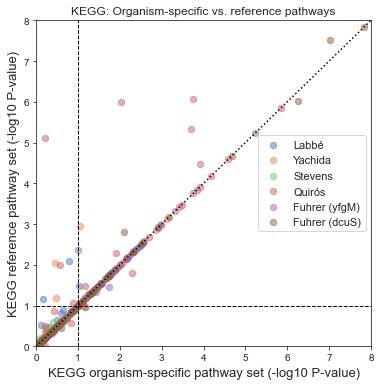

In [3]:
KEGG_reference_pathways = pd.read_csv("../data/KEGG_reference_pathways_compounds.csv", dtype=str, index_col=0)

def organism_vs_reference(db="KEGG"):
    d_sets = datasets

    plt_dict = {}
    res_lists = []
    for i in d_sets.keys():
        ora_res_org = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_ref = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], KEGG_reference_pathways)
        intersect = (set(ora_res_org["Pathway_ID"].str.slice(start=-5).tolist()) & set(ora_res_ref["Pathway_ID"].str.slice(start=-5).tolist()))
        common = set(set(ora_res_org[ora_res_org["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist()) & set(ora_res_ref[ora_res_ref["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist()))
        org_only = np.setdiff1d(ora_res_org[ora_res_org["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist(),
                                ora_res_ref[ora_res_ref["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist())
        ref_only = np.setdiff1d(ora_res_ref[ora_res_ref["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist(),
                                ora_res_org[ora_res_org["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist())
        res_lists.append([i, len(common), len(org_only), len(ref_only)])
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_ref = ora_res_ref[ora_res_ref["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org = ora_res_org[ora_res_org["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org_pvals = np.negative(np.log10(ora_res_org["P-value"].tolist()))
        ora_res_ref_pvals = np.negative(np.log10(ora_res_ref["P-value"].tolist()))
        plt_dict[i] = [ora_res_org_pvals, ora_res_ref_pvals]

    results_table = pd.DataFrame(res_lists, columns=["Dataset", "Common pathways", "Organism-specific only", "Reference only"])
    print(results_table)

    plt.figure(figsize=(6, 6))
    sns.set_style("ticks")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]
        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         fit_reg=False,
                         scatter_kws={'s': 40, 'alpha': 0.5, 'linestyle': 'None'})
    # ax.lines[3].set_linestyle("--")
    # ax.lines[4].set_linestyle("--")
    # ax.lines[5].set_linestyle("--")
    ax.set_xlabel("KEGG organism-specific pathway set (-log10 P-value)",
                  fontsize=13)
    ax.set_ylabel("KEGG reference pathway set (-log10 P-value)",
                  fontsize=13)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys(), fontsize=11)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG: Organism-specific vs. reference pathways")
    plt.show()

organism_vs_reference()

#### Calculate average pathway size

In [4]:
def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = list(set([str(i) for i in pathway_compounds if str(i) != "nan"]))
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [5]:
ref_paths = process_paths(KEGG_reference_pathways)
human_paths = process_paths(KEGG_human_pathways)
avg_ref_pathway_size = np.mean([len(v) for k, v in ref_paths.items()])
avg_hum_pathway_size = np.mean([len(v) for k, v in human_paths.items()])
# mouse_pathway_size = 
# eco_pathway_size = 
print("Average reference pathway size:", avg_ref_pathway_size)
print("Average human pathway size:", avg_hum_pathway_size)
print("Total reference pathways:", len(ref_paths))
print("Total human pathways:", len(human_paths))

Average reference pathway size: 44.88859416445624
Average human pathway size: 24.8203125
Total reference pathways: 377
Total human pathways: 256


#### Calculate Jaccard index for common pathways

In [13]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [47]:
def overlap_coefficient(list1, list2):
    # Szymkiewicz–Simpson coefficient
    intersection = len(list(set(list1).intersection(list(set(list2)))))
    smaller_set = min(len(list1), len(list2))
    return float(intersection) / smaller_set

In [51]:
common_paths_ref_human = list(set([i[3:] for i in ref_paths.keys()]) & set([i[3:] for i in human_paths.keys()]))

jaccard_indexes_human_ref = []
for pathway_id in common_paths_ref_human:
    jaccard_index = jaccard_similarity(ref_paths["map"+str(pathway_id)], human_paths["hsa"+str(pathway_id)])
    oc = overlap_coefficient(ref_paths["map"+str(pathway_id)], human_paths["hsa"+str(pathway_id)])
    jaccard_indexes_human_ref.append(oc)
#     jaccard_indexes_human_ref.append()
    
    
print("Median Overlap coefficient for common reference and human pathways:", np.median(jaccard_indexes_human_ref))
print("IQR: ", np.percentile(jaccard_indexes_human_ref, [25 ,75]))

Median Jaccard index for common reference and human pathways: 0.9166666666666666
IQR:  [0.83333333 0.96774194]


<a id='s4'></a>
## Pathway database choice

### Database size comparison

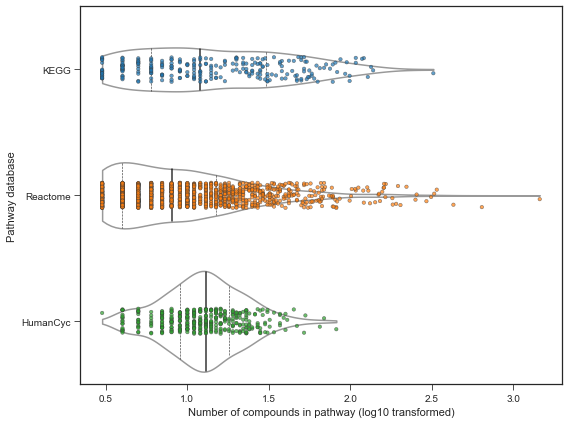

In [9]:
KEGG_pathway_df = pd.read_csv("../data/KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
Reactome_pathway_df = pd.read_csv("../data/Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathway_df[Reactome_pathway_df.index.str.contains("HSA")]
Metacyc_human_pathways = pd.read_csv("../data/Metacyc_human_pathways.csv", dtype=str, index_col=0)

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = list(set(KEGG_pathways.loc[pathway, :].tolist()))
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

KEGG_pathway_dict = process_paths(KEGG_pathway_df)
Reactome_pathway_dict = process_paths(Reactome_human_pathways)
metacyc_pathway_dict = process_paths(Metacyc_human_pathways)

pathway_length_KEGG = [np.log10(len(v)) for k, v in KEGG_pathway_dict.items()]
pathway_length_Reactome = [np.log10(len(v)) for k, v in Reactome_pathway_dict.items()]
pathway_length_metacyc = [np.log10(len(v)) for k, v in metacyc_pathway_dict.items()]

df = pd.DataFrame([pathway_length_KEGG, pathway_length_Reactome, pathway_length_metacyc]).T
df.columns = ["KEGG", "Reactome", "HumanCyc"]
df = df.melt(var_name='groups', value_name='vals')
plt.style.use("seaborn-ticks")
fig, ax1 = plt.subplots(figsize=(8,6))

ax = sns.violinplot(x=df.vals, y=df.groups, color="white", inner="quartile", edgecolor="k", cut=0)
ax = sns.stripplot(x=df.vals, y=df.groups, size=3.5, linewidth=0.5, alpha=0.7)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(0.6)
    l.set_color('black')
    l.set_alpha(0.8)
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.5)
    l.set_color('black')
    l.set_alpha(0.8)

plt.ylabel("Pathway database", fontsize=11)
plt.xlabel("Number of compounds in pathway (log10 transformed)", fontsize=11)
plt.tight_layout()
plt.savefig("../../Figures/Figure4a.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"},
           transparent=True)
plt.show()

### Pathway database updates -  Reactome (release 60-75)
Reactome has 4 major releases per year. How much do the human pathways change with each release?

In [10]:
def process_reactome_file(fname):
    infile = pd.read_csv(fname, sep="\t", header=None)
    infile = infile.astype(str)
    name_dict = dict(zip(infile[1], infile[3]))

    groups = infile.groupby([1])[0].apply(list).to_dict()
    df = pd.DataFrame.from_dict(groups, orient='index')
    pathway_ids = df.index.tolist()

    df['Pathway_name'] = df.index.map(name_dict)
    col = df.pop("Pathway_name")
    df.insert(0, "Pathway_name", col)
    return df

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = list(set(KEGG_pathways.loc[pathway, :].tolist()))
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "None"]
        
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [11]:
reactome_pathway_sets = []

directory = r"../data/Old_Reactome_All_Levels"
for filename in os.listdir(directory):
    if filename.startswith("ChEBI2Reactome"):
        processed_df = process_reactome_file("../data/Old_Reactome_All_Levels/"+filename)
        Reactome_human_pathways = processed_df[processed_df.index.str.contains("HSA")]
        reactome_pathway_sets.append({filename[-6:-4] : Reactome_human_pathways})


In [12]:
Reactome_pathway_dicts = {}
for i in reactome_pathway_sets:
    for k, v in i.items():

        reactome_dict = process_paths(v)
        Reactome_pathway_dicts.update({k: reactome_dict})
        
releases = sorted(Reactome_pathway_dicts.keys())
print(releases)
pathway_stats = pd.DataFrame(index=releases, columns=["Number of pathways", "Number of unique compounds", "Mean pathway size"])
for release in pathway_stats.index:
    pathway_stats.loc[release, "Number of pathways"] = len(Reactome_pathway_dicts[release])
    pathway_stats.loc[release, "Number of unique compounds"] = len(set([item for sublist in Reactome_pathway_dicts[release].values() for item in sublist]))
    pathway_stats.loc[release, "Mean pathway size"] = np.mean([len(i) for i in Reactome_pathway_dicts[release].values()])

['61', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '75']


In [12]:
pathway_stats

,Number of pathways,Number of unique compounds,Mean pathway size
61,1327,2988,17.464205
62,1325,2988,17.216604
63,1326,2987,17.259427
64,1354,3126,17.650665
65,1360,3145,17.527941
66,1374,3223,17.653566
68,1382,3312,18.070188
69,1390,3319,17.908633
70,1397,3291,17.850394
71,1490,3382,17.539597


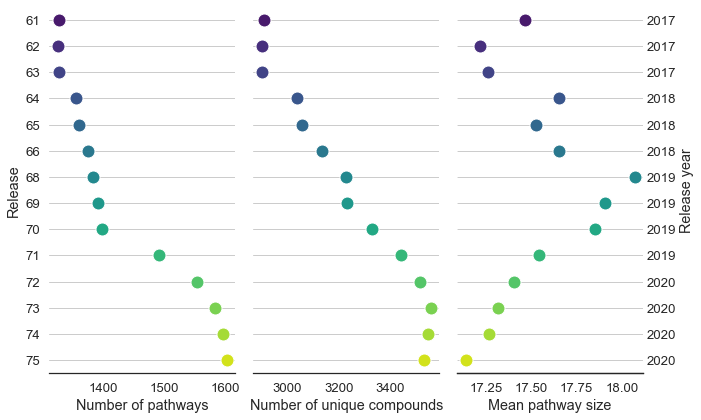

In [14]:
sns.set_style("white")
pathway_stats["Release"] = pathway_stats.index
pathway_stats["Year"] = ["2017", "2017", "2017","2018", "2018", "2018","2019", "2019", "2019", "2019", "2020", "2020", "2020", "2020"]
g = sns.PairGrid(pathway_stats.sort_values('Release', ascending=True),
                 x_vars = pathway_stats.columns[0:3], y_vars='Release', height=6, aspect=.55)



# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=13, orient="h", jitter=False,
      palette="viridis", linewidth=1, edgecolor="w")

# Use semantically meaningful titles for the columns
titles = ["a", "b", "c"]

for ax, title in zip(g.axes.flat, titles):
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)


ax2 = ax.twinx()
ax2.set(yticks=ax.get_yticks(), yticklabels=pathway_stats["Year"].tolist(), ylim=ax.get_ylim())
ax2.grid(False)
ax2.set_ylabel("Release year")
ax2.tick_params(axis=u'both', which=u'both',length=0, color="white")
ax.tick_params(color="white")
# ax.xticks(rotation = 45) 
sns.despine(left=True, bottom=False)
sns.set(font_scale=1)
plt.tight_layout()
plt.savefig("../../Figures/Figure4b.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"},
           transparent=True)
plt.show()

<a id='s5'></a>
## Metabolite misidentification
Here we simulate the effects of metabolite misidentification (4%) on ORA results.

### Pathway loss and pathway gain rate
The default number of simulations is 5. Increase the nsim parameter to a larger integer for more simulations. 

In [3]:
param_grid_heatmaps = {"random": [utils.misidentify_metabolites, 4, 3, 1, 2, [i for i in range(0, 70, 10)]],
                       "mass": [utils.misidentify_metabolites_by_mass, 4, 2, 7, 3, [i for i in range(1, 7, 1)]],
                       "formula": [utils.misidentify_metabolites_by_formula, 4, 2, 7, 3, [i for i in range(1, 6, 1)]]}


def misidentification_barplot(pg, db="KEGG"):

    """
    Plots TRP/FPR heatmap
    :param misidenetification_funct: function for misidentification
    :param db: Database, default is KEGG
    :return: heatmap
    """
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_TPR = []
    results_FPR = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Fuhrer"):
            original_pathways = pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]],
                                      nsim=1,
                                      zamboni=True)[4][0]

            for i in [4]:
                res = pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], nsim=100,
                            zamboni=True)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways)  # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = 1-(number_common_paths / total_significant_paths)
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len(
                        [i for i in x if i not in original_pathways]) / total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                sem_TPR = stats.sem(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                sem_FPR = stats.sem(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR, sem_TPR])
                results_FPR.append([d, i, avg_fraction_FPR, sem_FPR])

        else:
            original_pathways = \
                pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], nsim=1, zamboni=False)[4][
                    0]
            for i in [4]:
                res = \
                pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], nsim=100, zamboni=False)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways)  # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = 1-(number_common_paths / total_significant_paths)
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len(
                        [i for i in x if i not in original_pathways]) / total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                sem_TPR = stats.sem(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                sem_FPR = stats.sem(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR, sem_TPR])
                results_FPR.append([d, i, avg_fraction_FPR, sem_FPR])
    res_df_TPR = pd.DataFrame(results_TPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction", "SEM"])
    res_df_FPR = pd.DataFrame(results_FPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction", "SEM"])

    return res_df_TPR, res_df_FPR

print("starting..")
mass_TPR, mass_FPR = misidentification_barplot(param_grid_heatmaps["mass"], db="KEGG")
formula_TPR, formula_FPR = misidentification_barplot(param_grid_heatmaps["formula"], db="KEGG")
print("done.")


starting..
Labbé


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Yachida


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Stevens


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Quirós


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fuhrer (yfgM)


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fuhrer (dcuS)


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Labbé


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Yachida


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Stevens


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Quirós


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fuhrer (yfgM)


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fuhrer (dcuS)


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done.


In [123]:
mass_TPR["type"] = "mass"
formula_TPR["type"] = "formula"
combined_TPR = pd.concat([mass_TPR, formula_TPR])
mass_FPR["type"] = "mass"
formula_FPR["type"] = "formula"
combined_FPR = pd.concat([mass_FPR, formula_FPR])

In [124]:
combined_TPR["Average fraction"] = -combined_TPR["Average fraction"]
combined_TPR

,Dataset,Percentage misidentification,Average fraction,SEM,type
0,Labbé,4,-0.152000,0.012038,mass
1,Yachida,4,-0.080000,0.012247,mass
2,Stevens,4,-0.060000,0.010050,mass
3,Quirós,4,-0.117551,0.005795,mass
4,Fuhrer (yfgM),4,-0.043333,0.004080,mass
5,Fuhrer (dcuS),4,-0.051111,0.003639,mass
0,Labbé,4,-0.169000,0.012788,formula
1,Yachida,4,-0.079167,0.010619,formula
2,Stevens,4,-0.070000,0.010000,formula
3,Quirós,4,-0.116531,0.005327,formula


<ipython-input-239-7692e88c999e>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round((abs(x)), 1) for x in ax.get_yticks()], fontsize=12)


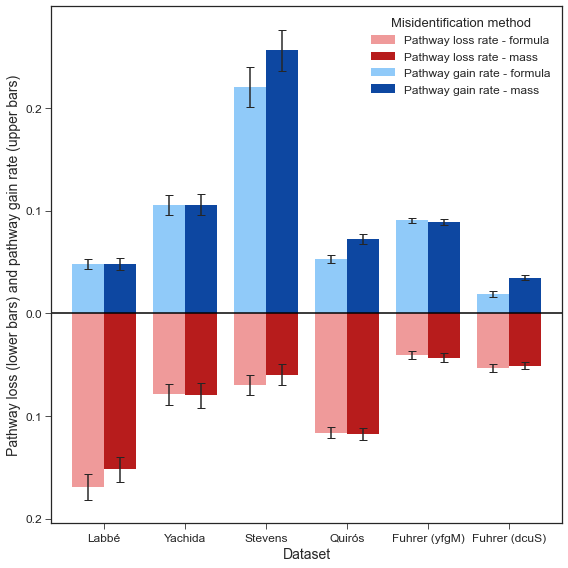

In [239]:
fix, ax = plt.subplots(figsize=(8, 8))
combined_TPR.pivot(columns="type", index="Dataset").reindex(["Labbé", "Yachida", "Stevens", "Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]).plot.bar(y="Average fraction",
                                                                                                                                                  ax=ax,
                                                                                                                                                 color={"mass": "#B71C1C", "formula": "#EF9A9A"},
                                                                                                                                                 width=0.8,
                                                                                                                                                 yerr="SEM",
                                                                                                                                                 capsize=4)
combined_FPR.pivot(columns="type", index="Dataset").reindex(["Labbé", "Yachida", "Stevens", "Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]).plot.bar(y="Average fraction",
                                                                                                                                                  ax=ax,
                                                                                                                                                  color={"mass": "#0D47A1", "formula": "#90CAF9"},
                                                                                                                                                 width=0.8,
                                                                                                                                                 yerr="SEM",
                                                                                                                                                 capsize=4)
ax.legend(["Pathway loss rate - formula", "Pathway loss rate - mass", "Pathway gain rate - formula", 'Pathway gain rate - mass'],
         fontsize=12,
         title = "Misidentification method",
         title_fontsize=13)
ax.axhline(y=0, color="k")
ax.set_xlabel("Dataset", fontsize=14)
ax.set_yticklabels([round((abs(x)), 1) for x in ax.get_yticks()], fontsize=12)
ax.set_xticklabels(["Labbé", "Yachida", "Stevens", "Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"], fontsize=12)
ax.set_ylabel("Pathway loss (lower bars) and pathway gain rate (upper bars)",  fontsize=14)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)
plt.tight_layout()

# plt.savefig("../../Figures/pathway_gain_loss_mass_formula_4_pct_combined.tiff",
#             dpi=600, format="tiff",
#             pil_kwargs={"compression": "tiff_lzw"},
#            transparent=True)
plt.show()

<a id='s6'></a>
## Metabolite polarity

Which areas of the KEGG metabolic network can different chromatography types access?

In [242]:
stevens_raw = pd.read_csv("../example_data/Stevens_matrix_named_compounds_only.csv", dtype="object")

In [243]:
stevens_raw_ch_type = stevens_raw.loc[:, ["PLATFORM", "KEGG"]]
stevens_raw_ch_type

,PLATFORM,KEGG
0,Method 3,C10759
1,Method 3,NaN
2,Method 3,NaN
3,Method 3,NaN
4,Method 2,NaN
...,...,...
944,Method 4,C00385
945,Method 3,C01762
946,Method 3,C02470
947,Method 2,NaN


In [245]:
method1 = stevens_data.proc_mat[[c for c in stevens_data.proc_mat.columns if c in chrom_groups[chrom_groups["PLATFORM"] == "Method 1"]["KEGG"].tolist()]+ ["Group"]]
method2 = stevens_data.proc_mat[[c for c in stevens_data.proc_mat.columns if c in chrom_groups[chrom_groups["PLATFORM"] == "Method 2"]["KEGG"].tolist()]+ ["Group"]]
method3 = stevens_data.proc_mat[[c for c in stevens_data.proc_mat.columns if c in chrom_groups[chrom_groups["PLATFORM"] == "Method 3"]["KEGG"].tolist()]+ ["Group"]]
method4 = stevens_data.proc_mat[[c for c in stevens_data.proc_mat.columns if c in chrom_groups[chrom_groups["PLATFORM"] == "Method 4"]["KEGG"].tolist()]+ ["Group"]]

In [291]:
# Which pathways can each method access?
f = KEGG_human_pathways.dropna(axis=0, how='all', subset=KEGG_human_pathways.columns.tolist()[1:])
name_dict = dict(zip(f.index, f['Pathway_name']))
pathway_dict = {k: list(set(f.loc[k, '0':].tolist())) for k in list(name_dict.keys())}
pathway_dict = {k: [i for i in v if pd.notnull(i)] for k, v in pathway_dict.items()}
pathway_dict = {k: v for k, v in pathway_dict.items() if len(v) > 2}

pathwayspresent1 = {k: v for k, v in pathway_dict.items() if len([i for i in method1.columns if i in v]) > 1}
pathwayspresent2 = {k: v for k, v in pathway_dict.items() if len([i for i in method2.columns if i in v]) > 1}
pathwayspresent3 = {k: v for k, v in pathway_dict.items() if len([i for i in method3.columns if i in v]) > 1}
pathwayspresent4 = {k: v for k, v in pathway_dict.items() if len([i for i in method4.columns if i in v]) > 1}
pathwayspresentall = {k: v for k, v in pathway_dict.items() if len([i for i in stevens_data.proc_mat.columns if i in v]) > 1}


In [292]:
pdict = {"m1": pathwayspresent1.keys(),
        "m2": pathwayspresent2.keys(),
        "m3": pathwayspresent3.keys(),
        "m4": pathwayspresent4.keys()}

In [280]:
# Find the overlap in pathways accessible using the different separation methods

import itertools
combs = itertools.combinations(["m1", "m2", "m3", "m4"], 2)
# print([i for i in combs])
for c in combs:
    print(c)
    a = pdict[c[0]]
    b = pdict[c[1]]
    overlap = len(set(a) & set(b))
    print(overlap)

('m1', 'm2')
5
('m1', 'm3')
28
('m1', 'm4')
28
('m2', 'm3')
2
('m2', 'm4')
1
('m3', 'm4')
24
